# Baseline Modelling with ANN

By: Yolanda Chen

Date: February 23th, 2021

Resources:

I think we said not to use this, but keeping it here in case we want to quickly train a model: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.fit

Again, similar process but we're going to build an ANN similar to what we've built in labs instead: https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0

https://medium.com/@pk_500/music-genre-classification-using-feed-forward-neural-network-using-pytorch-fdb9a960a964

**1. Load MFCC data and labels (genre) from JSON**

https://www.programiz.com/python-programming/json

https://www.programiz.com/python-programming/dictionary

https://stackoverflow.com/questions/55109684/how-to-handle-large-json-file-in-pytorch

In [17]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [75]:
def get_data_loader(dataset, batch_size):

  """ 1. Split dataset into training and testing dataset """

  # Compute the suitable lengths of the training and testing datasets
  
  # TEMP: Set a small dataset
  num_train_data = int(0.01 * len(dataset))
  num_test_data = int(len(dataset) - num_train_data)

  # Split dataset into training and testing datasets using random_split
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, (num_train_data, num_test_data))


  """ 2. Split original training set into a new training set and validation set """

  # Randomize list of data indices
  train_size = len(train_dataset)
  dataset_indices = list(range(train_size))
  np.random.seed(1000)
  np.random.shuffle(dataset_indices)

  # Split into training and testing indices
  split = int(0.8 * train_size)
  train_indices, val_indices = dataset_indices[:split], dataset_indices[split:]

  # Split dataset into training and testing datasets using SubsetRandomSampler
  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

  """ 3. DataLoad the training, validation, and testing sets """
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True, sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True, sampler=val_sampler)
  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=True)

  return train_loader, val_loader, test_loader

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [76]:
# Load json file
with open('gdrive/My Drive/APS360 Project/our_spec/our_spec_new.json') as file:
  data = json.load(file)

# Extract mfcc and labels
mfcc = data['mfcc']
labels = data['labels']

#print(mfcc[0])
#print(labels[0])

# Convert list to tensor and create dataset of mfcc and labels
dataset = torch.utils.data.TensorDataset(torch.Tensor(mfcc), torch.Tensor(labels))
train_loader, val_loader, test_loader = get_data_loader(dataset, 1)

Check input dimensions

In [77]:
print(len(train_loader))
print(len(val_loader))

63
16


**2. Multiclass-ANN Architecture**

Similar to what has been done in labs

Need to modify input size to match the input dimensions

Start off with a small network just to check

In [80]:
class GenreClassifier(nn.Module):
    def __init__(self):
        super(GenreClassifier, self).__init__()
        self.layer1 = nn.Linear(880, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 8) # 8 genres
    def forward(self, input):
        flattened = input.view(-1, 880)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [22]:
def get_accuracy(model, train=False):

    correct = 0
    total = 0

    if train == True:
      data = train_loader
    else:
      data = val_loader

    for input, labels in data:
        output = model(input)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input.shape[0]
        
    return correct / total

In [106]:
def train(model, train_loader, batch_size=64, num_epochs=1):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for input, labels in iter(train_loader):
            out = model(input)            # forward pass

            #print(out)
            #print(labels.long())

            loss = criterion(out, labels.long()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**4. Training**

Sanity check with small dataset

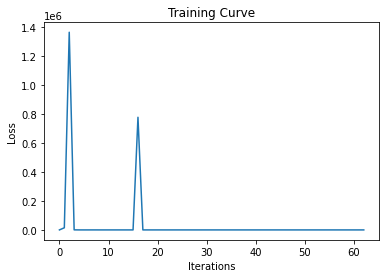

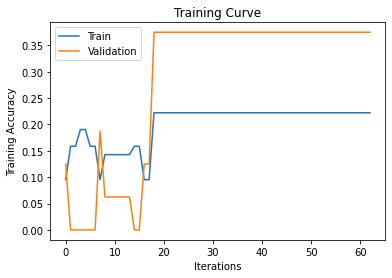

Final Training Accuracy: 0.2222222222222222
Final Validation Accuracy: 0.375


In [107]:
model = GenreClassifier()
train(model, train_loader, batch_size=1, num_epochs=1)